In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None # affiche toutes les colonnes lors de l'affichage des DataFrames
pd.options.display.float_format = '{:.2f}'.format # affiche les nombres à virgule flottante avec 2 décimales

# Import

In [3]:
# lecture des données de circulation :
df_raw = pd.read_parquet("../data/2-clean/slo_2024.parquet")

In [4]:
# lecture des données sur les gares :
gares = pd.read_parquet("../data/2-clean/gares-de-voyageurs.parquet")

# Merge

In [5]:
# pour chaque trajet, on récupère 'code_departement', 'nom_departement' et 'region' dans la table 'gares' via le 'code_ci' de la gare de destination 
df = df_raw.merge(gares.set_index('code_ci')[['code_departement', 'nom_departement', 'region']], left_on='code_ci_destination', right_index=True, how='left')

# Analyse

In [363]:
# Ajout de colonnes simplifiées : True si le train a plus de n minutes de retard à l'arrivée
df['ret_arrivee_5min'] = df['ret_arrivee_obs_min'] >= 5
df['ret_arrivee_10min'] = df['ret_arrivee_obs_min'] >= 10
df['ret_arrivee_15min'] = df['ret_arrivee_obs_min'] >= 15
df['ret_arrivee_30min'] = df['ret_arrivee_obs_min'] >= 30
df['ret_arrivee_60min'] = df['ret_arrivee_obs_min'] >= 60

In [7]:
# top 10 des plus grands retards à l'arrivée : 
df.sort_values(by='ret_arrivee_obs_min', ascending=False).head() 

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ch_origine,code_ci_destination,lib_ci_destination,code_ch_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee,code_departement,nom_departement,region,ret_arrivee_5min,ret_arrivee_10min,ret_arrivee_15min
99400,85272125,2024-05-24,5224,286005,Lille-Flandres,BV,481002,Nantes,BV,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-05-23 09:36:00,2024-05-24 09:35:46,2024-05-24 09:35:46,2024-05-23 14:44:00,2024-05-24 14:41:04,2024-05-24 14:41:04,704196,86386.00,1439.77,86224.00,1437.07,[60+],308.00,>3h,305.30,5,4,9,14,44,Loire-Atlantique,Pays de la Loire,True,True,True
63797,84338849,2024-04-03,8537,391003,Paris-Montparnasse,BV,677005,Hendaye,00,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV - Atlantique, à charge",TGV2N2,TGV2N2,2024-04-03 10:04:00,2024-04-03 10:03:20,2024-04-03 10:03:20,2024-04-03 14:47:00,2024-04-04 02:27:00,2024-04-04 02:27:00,769999,-40.00,-0.67,42000.00,700.00,[60+],283.00,>3h,983.67,4,2,10,2,64,Pyrénées-Atlantiques,Nouvelle-Aquitaine,True,True,True
159272,86872362,2024-08-17,4080,481002,Nantes,BV,484006,Angers-St-Laud,BV,OSLO,"GL Inter-Villes - Train classique, VL>= 160 km/h","GL Inter-Villes - Train classique, VL>= 160 km/h",22200,22200,2024-08-17 06:40:00,2024-08-17 06:39:37,2024-08-17 06:39:37,2024-08-17 07:22:00,2024-08-17 18:15:42,2024-08-17 18:15:42,87422,-23.00,-0.38,39222.00,653.70,[60+],42.00,<1h30,696.08,8,5,6,18,49,Maine-et-Loire,Pays de la Loire,True,True,True
144775,86491551,2024-07-26,7668,286542,Tourcoing,BV,581009,Bordeaux-St-Jean,BV,SNCF-VOYAGES,"TAGV haute capacité Nord, à charge","TAGV haute capacité Nord, à charge",TGVDAS,TGVDAS,2024-07-26 06:02:00,2024-07-26 10:42:00,2024-07-26 10:42:00,2024-07-26 11:02:00,2024-07-26 21:16:13,2024-07-26 21:16:13,918736,16800.00,280.00,36853.00,614.22,[60+],300.00,>3h,634.22,7,4,10,21,33,Gironde,Nouvelle-Aquitaine,True,True,True
144553,86489397,2024-07-26,5260,581009,Bordeaux-St-Jean,BV,286005,Lille-Flandres,BV,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-07-26 05:58:00,2024-07-26 05:58:01,2024-07-26 05:58:01,2024-07-26 10:42:00,2024-07-26 20:31:13,2024-07-26 20:31:13,888008,1.00,0.02,35353.00,589.22,[60+],284.00,>3h,873.20,7,4,5,20,59,Nord,Hauts-de-France,True,True,True


In [8]:
# on va ignorer le retard > 1400 minutes, c'est aberrant et ça casse tous les graphiques après
df = df[df['ret_arrivee_obs_min'] <= 1400]

In [9]:
# top 10 des plus grandes avances au départ
df.sort_values(by='ret_depart_obs_min', ascending=True).head() 

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ch_origine,code_ci_destination,lib_ci_destination,code_ch_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee,code_departement,nom_departement,region,ret_arrivee_5min,ret_arrivee_10min,ret_arrivee_15min
29742,83385299,2024-02-11,6124,751081,Marseille-Blancarde,BV,686006,Paris-Gare-de-Lyon,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-02-11 15:46:00,2024-02-10 15:32:28,2024-02-10 15:32:28,2024-02-11 19:23:00,2024-02-11 19:26:51,2024-02-11 19:26:51,753375,-87212.00,-1453.53,231.00,3.85,"[0,5[",217.00,>3h,1674.38,2,6,15,19,75,Paris,Ile-de-France,False,False,False
67789,84446252,2024-04-08,6689,722439,Givors-Canal,BV,726000,St-Étienne-Châteaucreux,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-04-08 21:22:30,2024-04-08 06:35:59,2024-04-08 06:35:59,2024-04-08 21:48:00,2024-04-08 21:48:16,2024-04-08 21:48:16,37127,-53191.00,-886.52,16.00,0.27,"[0,5[",25.50,<1h30,912.28,4,0,6,21,42,Loire,Auvergne-Rhône-Alpes,False,False,False
97350,85213756,2024-05-21,7106,343004,Valenciennes,BV,271007,Paris-Nord,BV,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGV-D,TGV-D,2024-05-21 06:57:00,2024-05-20 20:16:49,2024-05-20 20:16:49,2024-05-21 08:49:00,2024-05-21 08:50:24,2024-05-21 08:50:24,239453,-38411.00,-640.18,84.00,1.40,"[0,5[",112.00,1h30-3h,753.58,5,1,20,8,75,Paris,Ile-de-France,False,False,False
22249,83177938,2024-02-03,6250,688887,Montpellier (CNM),BV,686006,Paris-Gare-de-Lyon,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-02-03 07:52:00,2024-02-02 22:40:27,2024-02-02 22:40:27,2024-02-03 11:04:00,2024-02-03 11:20:57,2024-02-03 11:20:57,731079,-33093.00,-551.55,1017.00,16.95,"[15,30[",192.00,>3h,760.50,2,5,22,11,75,Paris,Ile-de-France,True,True,True
101138,85319775,2024-05-26,6180,756056,Nice-Ville,00,686006,Paris-Gare-de-Lyon,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-05-26 16:58:00,2024-05-26 07:57:55,2024-05-26 07:57:55,2024-05-26 22:38:00,2024-05-26 23:13:59,2024-05-26 23:13:59,971692,-32405.00,-540.08,2159.00,35.98,"[30,60[",340.00,>3h,916.07,5,6,7,23,75,Paris,Ile-de-France,True,True,True


Text(0.5, 1.0, "Répartition des retards à l'arrivée selon la durée du trajet")

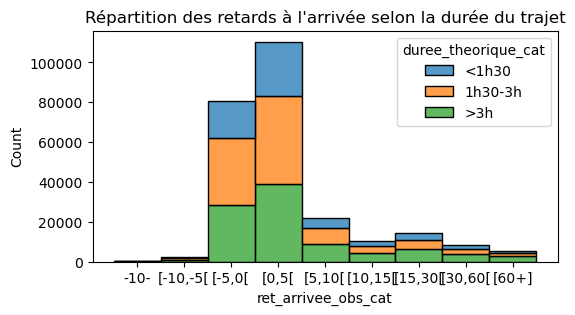

In [10]:
# Répartition des retards à l'arrivée selon la durée du trajet
plt.figure(figsize=(6,3))
sns.histplot(data=df, x="ret_arrivee_obs_cat", hue="duree_theorique_cat", multiple="stack", stat="count")
plt.title("Répartition des retards à l'arrivée selon la durée du trajet")

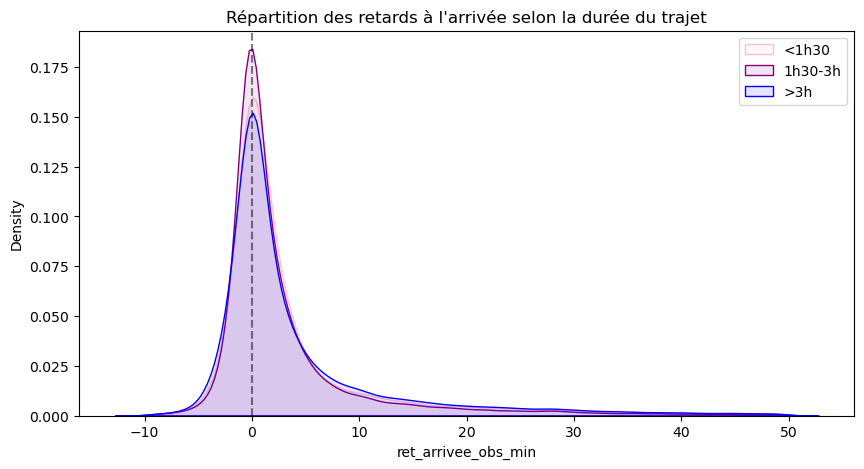

In [11]:
# Répartition des retards à l'arrivée selon la durée du Trajet
plt.figure(figsize=(10,5))
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50) & (df['duree_theorique_cat'] == '<1h30')], x='ret_arrivee_obs_min', fill=True, color='pink', alpha=0.1)
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50) & (df['duree_theorique_cat'] == '1h30-3h')], x='ret_arrivee_obs_min', fill=True, color='purple', alpha=0.1)
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50) & (df['duree_theorique_cat'] == '>3h')], x='ret_arrivee_obs_min', fill=True, color='blue', alpha=0.1)
plt.legend(['<1h30', '1h30-3h', '>3h'])
plt.title("Répartition des retards à l'arrivée selon la durée du trajet")
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# constat : les trains de 3 h sont légèrement plus en retard (autant au départ qu'à l'arrivée), mais c'est subtil

Text(0.5, 1.0, "Répartition des retards à l'arrivée (entre -10 min et +50 min)")

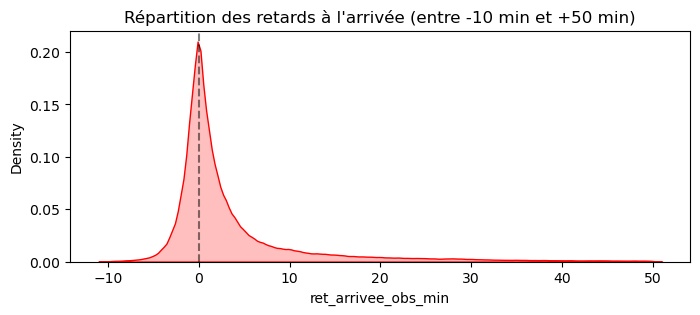

In [12]:
# Réparatition des retards à l'arrivée
plt.figure(figsize=(8,3))
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50)]['ret_arrivee_obs_min'], fill=True, bw_adjust=0.5, color='r')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title("Répartition des retards à l'arrivée (entre -10 min et +50 min)")

Text(0.5, 1.0, 'Répartition des retards au DEPART (entre -10 min et +50 min)')

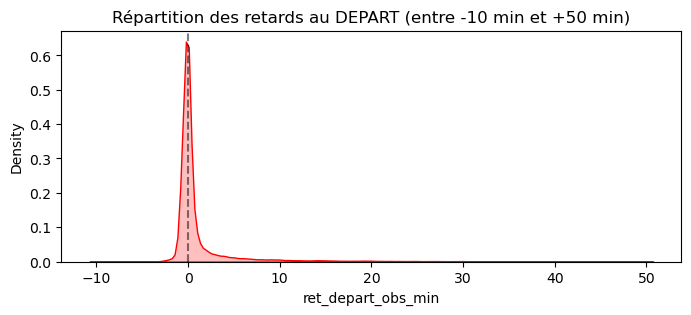

In [13]:
# Réparatition des retards au départ
plt.figure(figsize=(8,3))
sns.kdeplot(df[(df['ret_depart_obs_min'] >= -10) & (df['ret_depart_obs_min'] <= 50)]['ret_depart_obs_min'], fill=True, bw_adjust=0.5, color='r')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title("Répartition des retards au DEPART (entre -10 min et +50 min)")
# constat : les trains sont nettement plus ponctuels au départ qu'à l'arrivée (cloche plus resserée et pic à 0.6 sur x=0, contre seulement 0.2 à l'arrivée)

In [14]:
# calcul de la corrélation entre duree_theorique_min et ret_arrivee_obs_min
df[['duree_theorique_min', 'ret_arrivee_obs_min']].corr()
# constat : aucune corrélation entre durée du trajet et retard

,duree_theorique_min,ret_arrivee_obs_min
duree_theorique_min,1.00,0.06
ret_arrivee_obs_min,0.06,1.00


<Axes: xlabel='duree_theorique_min', ylabel='ret_arrivee_obs_min'>

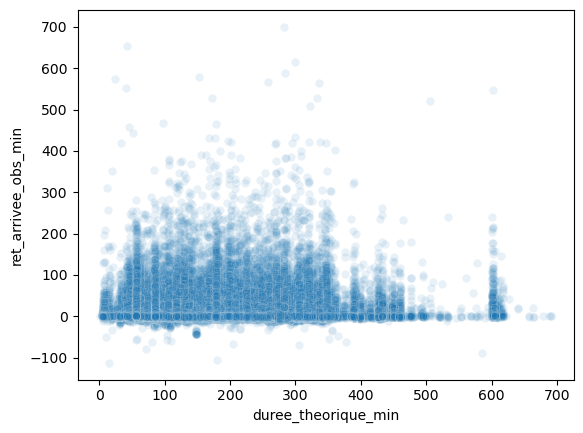

In [15]:
# Répartition des retards selon la durée du trajet (scatterplot)
sns.scatterplot(data=df, x="duree_theorique_min", y="ret_arrivee_obs_min", alpha=0.1)
# constat : aucune corrélation entre durée du trajet et retard

Text(0.5, 1.0, "Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée")

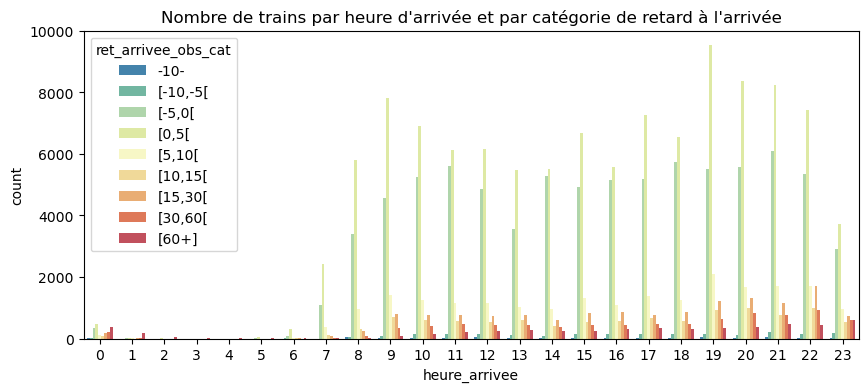

In [16]:
# Affiche le nombre de ret_arrivee_obs_cat par heure_arrivee
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_obs_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='heure_arrivee', hue='ret_arrivee_obs_cat', palette=palette)
plt.title("Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée")

Text(0.5, 1.0, "Nombre de trains par mois et par catégorie de retard à l'arrivée")

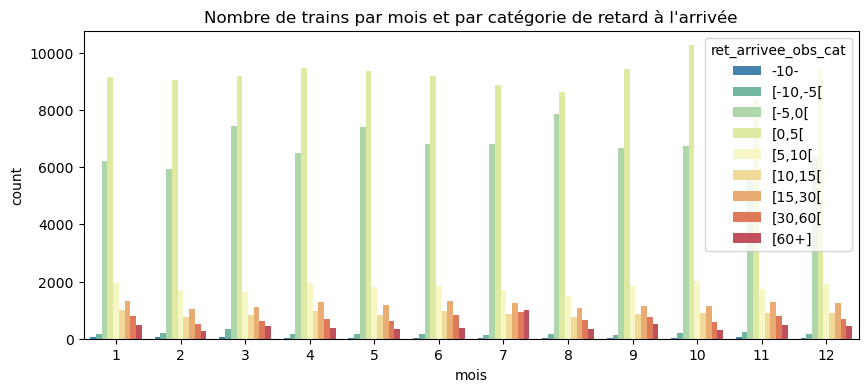

In [17]:
# Affiche le nombre de ret_arrivee_obs_cat par mois
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_obs_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='mois', hue='ret_arrivee_obs_cat', palette=palette)
plt.title("Nombre de trains par mois et par catégorie de retard à l'arrivée")

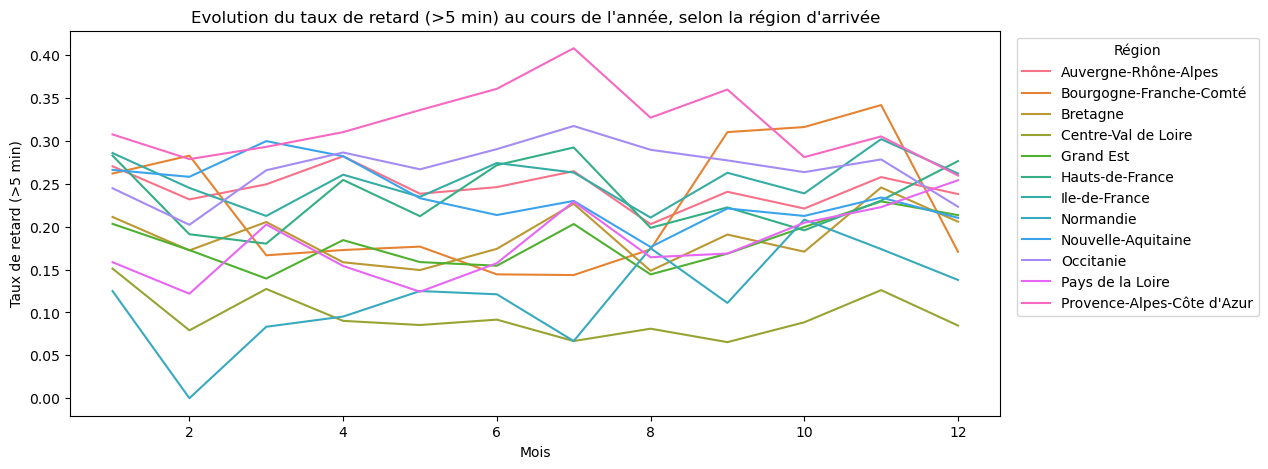

In [43]:
# Evolution des retards au cours de l'année, selon la région d'arrivée
retard_5min_mensuel = df.groupby(['mois', 'region']).agg(
    taux_retard = ('ret_arrivee_5min', 'mean'),
    region = ('region', 'first')
)
plt.figure(figsize=(12, 5))
sns.lineplot(data=retard_5min_mensuel, x='mois', y='taux_retard', hue='region')
plt.title("Evolution du taux de retard (>5 min) au cours de l'année, selon la région d'arrivée")
plt.xlabel("Mois")
plt.ylabel("Taux de retard (>5 min)")
plt.legend(title='Région', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

In [23]:
# gares d'arrivée les plus populaires
df['lib_ci_destination'].value_counts()

lib_ci_destination
Paris-Gare-de-Lyon    32805
Paris-Montparnasse    26759
Paris-Nord            19262
Paris-Est             15149
Wannehain             13027
                      ...  
Troyes                    1
St-Claude                 1
Rives                     1
Albi-Ville                1
Belfort                   1
Name: count, Length: 228, dtype: Int64

In [24]:
# constat : 50% des trajets ne sont empruntés que 10 fois ou moins
df['num_marche'].value_counts().describe()

count   2461.00
mean     103.21
std      138.51
min        1.00
25%        1.00
50%       10.00
75%      246.00
max      366.00
Name: count, dtype: Float64

In [25]:
# Taux de retard en fonction du trajet effectué (pour les trajets num_marche ayant au moins n occurences)
n = 10
# conserve uniquement les marches ayant un minimum de n circulations (n occurences dans le tableau)
marches_n_circulations = df['num_marche'].value_counts()[lambda x: x >= n].index
retard_num_marche = df[df['num_marche'].isin(marches_n_circulations)].groupby('num_marche').agg(
    origine = ('lib_ci_origine', 'first'),
    destination = ('lib_ci_destination', 'first'),
    retard_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nombre_circulations = ('id_circ', 'count')
).sort_values(by='retard_median', ascending=False)
retard_num_marche.head(10)

,origine,destination,retard_moyen,retard_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,nombre_circulations
num_marche,,,,,,,,
26823,Lyon-Part-Dieu,Montpellier-St-Roch,45.68,49.05,1.00,0.92,0.92,13
26986,Chambéry-Challes-les-Eaux,Paris-Gare-de-Lyon,47.76,35.90,0.76,0.76,0.76,17
26514,Bordeaux-St-Jean,Paris-Montparnasse,48.62,31.02,0.58,0.58,0.58,12
26864,Lyon-Part-Dieu,Marne-la-Vallée-Chessy,34.80,27.56,0.79,0.64,0.57,14
26560,Dax,Paris-Montparnasse,46.86,23.65,0.62,0.56,0.50,16
9362,Wannehain,Paris-Nord,35.69,23.45,0.76,0.65,0.65,17
26702,Rennes,Paris-Montparnasse,30.99,21.88,0.71,0.62,0.57,21
9468,Stiring-Wendel,Paris-Est,37.40,19.98,0.65,0.61,0.57,88
26320,Arras,Paris-Nord,44.80,19.59,0.60,0.60,0.60,10


In [26]:
# Taux de retard parmi les n gares d'arrivée les plus courantes -> #TODO utiliser plutot le segment DRG issu de "gares"
n = 50
top_n_gares = df['lib_ci_destination'].value_counts().head(n).index
retard_5min_gare = df[df['lib_ci_destination'].isin(top_n_gares)].groupby('lib_ci_destination').agg(
    retard_median = ('ret_arrivee_obs_min', 'median'),
    retard_moyen = ('ret_arrivee_obs_min', 'mean'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nombre_circulations = ('id_circ', 'count')
    ).sort_values(by='taux_retard_5min', ascending=False)
retard_5min_gare.head(10)

,retard_median,retard_moyen,taux_retard_5min,taux_retard_10min,taux_retard_15min,nombre_circulations
lib_ci_destination,,,,,,
Nice-Ville,3.29,13.23,0.41,0.28,0.21,3582
Lyon-Part-Dieu,2.57,8.29,0.33,0.19,0.13,4951
Paris-Nord,2.08,7.89,0.32,0.22,0.16,19262
Grenoble,2.00,7.57,0.32,0.20,0.14,2493
Montpellier-St-Roch,0.67,8.54,0.31,0.22,0.18,1656
Montpellier (CNM),1.18,7.52,0.30,0.19,0.14,2638
Marseille-St-Charles,1.67,8.59,0.30,0.20,0.15,9504
St-Étienne-Châteaucreux,1.54,5.74,0.28,0.14,0.09,1234
Bordeaux-St-Jean,1.35,6.77,0.27,0.16,0.11,5824


Text(0.5, 1.0, "Retard à l'arrivée en fonction de la longueur du trajet")

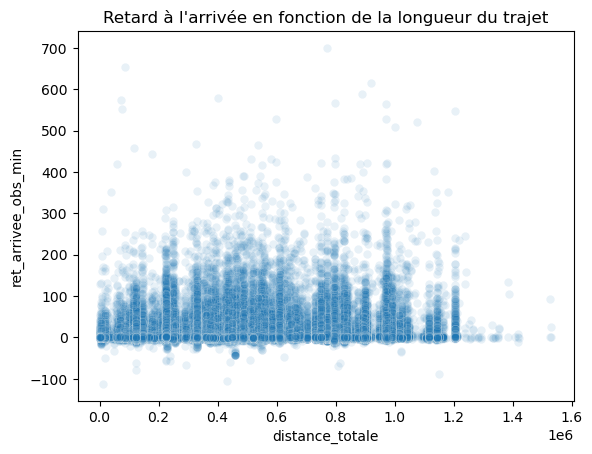

In [351]:
# Taux de retard en fonction de la longueur du trajet (distance_totale)
sns.scatterplot(data=df, x='distance_totale', y='ret_arrivee_obs_min', alpha=0.1)
plt.title("Retard à l'arrivée en fonction de la longueur du trajet")
# constat : la distance ne semble pas être un facteur de retard

Text(500, 450, 'f(x)=x')

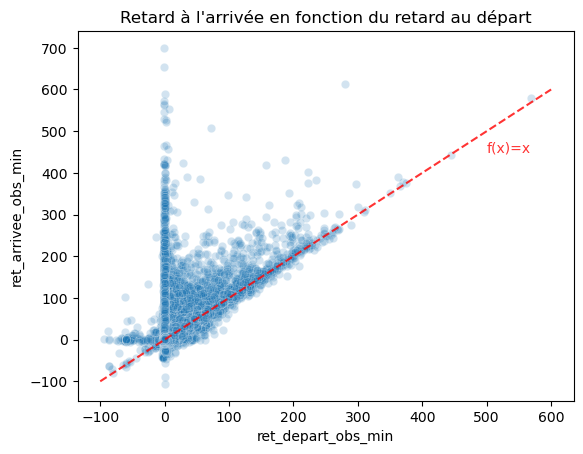

In [350]:
# Retard à l'arrivée en fonction du retard au départ
sns.scatterplot(data=df[df['ret_depart_obs_min'] > -100], x='ret_depart_obs_min', y='ret_arrivee_obs_min', alpha=0.2)
# constat : 
# - ligne verticale à x=0 : trains l'heure au départ, mais avec du retard à l'arrivée 
# - droite oblique : les trains qui ont conservé leur retard initial.
# - f(x)<x (sous la droite rouge) : trains qui ont récupéré un petit peu de leur retard initial 
# - f(x)>x (au dessus de la droite): les trains qui ont pris du retard au cous du trajet, en plus de leur retard initial.

# trace f(x) = x
plt.plot([-100, 600], [-100, 600], color='red', linestyle='--', alpha=0.8)
plt.title("Retard à l'arrivée en fonction du retard au départ")
plt.text(500, 450, "f(x)=x", color='red', alpha=0.8)

In [48]:
# Taux de retard selon le département de destination
retard_par_departement = df.groupby('code_departement').agg(
    nom_departement = ('nom_departement', 'first'),
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    nb_circulations = ('id_circ', 'count')
)
retard_par_departement.head()

,nom_departement,retard_arrivee_moyen,retard_arrivee_median,nb_circulations
code_departement,,,,
01,Ain,7.49,1.50,2732
02,Aisne,-0.85,-0.85,1
03,Allier,2.84,2.00,19
05,Hautes-Alpes,67.00,67.00,2
06,Alpes-Maritimes,13.38,3.32,3589


In [30]:
# Taux de retard par région d'arrivée
retard_par_region = df.groupby('region').agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nb_circulations = ('id_circ', 'count')
)
retard_par_region.sort_values(by='taux_retard_15min', ascending=False)

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,nb_circulations
region,,,,,,
Provence-Alpes-Côte d'Azur,9.49,1.90,0.32,0.22,0.16,15496
Occitanie,6.93,0.17,0.27,0.19,0.14,12067
Hauts-de-France,6.20,0.93,0.23,0.16,0.12,35138
Ile-de-France,6.46,1.18,0.25,0.16,0.11,97225
Auvergne-Rhône-Alpes,6.04,1.12,0.25,0.15,0.11,25306
Normandie,2.63,-2.00,0.12,0.11,0.10,322
Bourgogne-Franche-Comté,5.79,0.90,0.21,0.13,0.10,1851
Pays de la Loire,5.53,0.00,0.18,0.13,0.10,11525
Nouvelle-Aquitaine,5.64,0.53,0.24,0.14,0.09,14394


In [31]:
# Taux de retard_5min par type de trajet (lib_tct_arrivee)
retard_par_libtct = df.groupby('lib_tct_arrivee').agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nb_circulations = ('id_circ', 'count')
)
retard_par_libtct.sort_values(by='taux_retard_5min', ascending=False)

# constats :
# - certains axes sont plus en retard : sud-est > bretagne > est # TODO ajouter une variable indiquant l'axe
# - trains haute capacité semblent avoir sytématiquement plus de retard : # TODO ajouter une variable indiquant le type de train

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,nb_circulations
lib_tct_arrivee,,,,,,
"Voyageurs internationaux - VL<160km/h non TAGV (hors spéciaux), à charge",25.16,5.10,0.51,0.44,0.39,190
"TAGV international France Angleterre, à charge",7.29,2.17,0.34,0.21,0.15,928
"TAGV spéciaux nationaux (pèlerins et autres), à charge",10.28,2.00,0.33,0.23,0.19,271
"TAGV International France Espagne, à charge",8.34,1.58,0.33,0.22,0.16,1588
"TAGV International France Italie, à charge",7.31,2.30,0.31,0.17,0.10,1009
"TAGV International France-Espagne, à charge",7.74,1.67,0.30,0.18,0.12,1421
"TAGV haute capacité Nord, à charge",8.92,1.23,0.30,0.21,0.16,5668
"TAGV International France Allemagne, à charge",6.91,1.28,0.29,0.19,0.13,7790
TAGV (Train A Grande Vitesse - à charge),7.02,1.18,0.28,0.20,0.15,33934


In [82]:
# encodage des variables catégorielles
df_encoded = df.copy()
df_encoded = df_encoded.drop(columns=['ret_depart_obs_sec', 'ret_arrivee_obs_sec', 'ret_arrivee_obs_cat']) 
for col in df_encoded.select_dtypes(include=['object','string','category']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

In [86]:
# calcul des corrélations
df_encoded_corr = df_encoded.corr()

Text(0.5, 1.0, 'Heatmap de corrélation entre le variables')

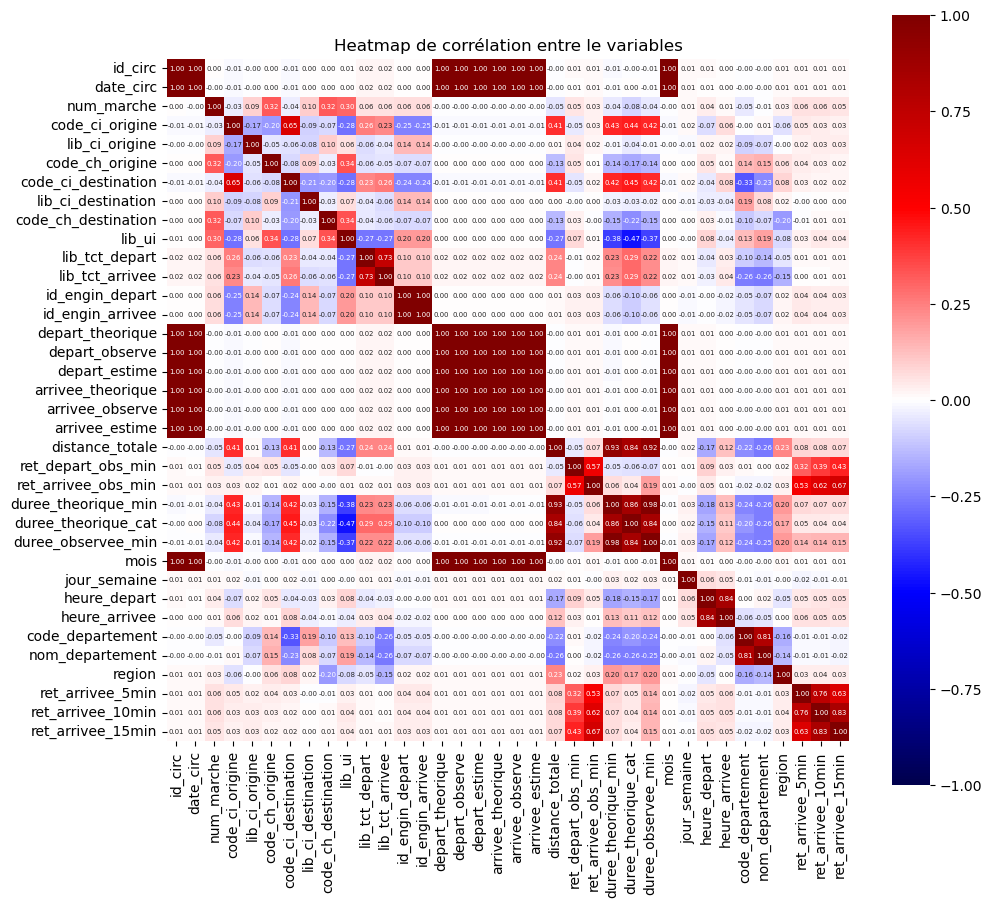

In [87]:
# heatmap de corrélation
plt.figure(figsize=(11, 10))
plt.gca().set_aspect('equal', adjustable='box')
sns.heatmap(df_encoded_corr, annot=True, fmt=".2f", cmap="seismic", vmax=1, vmin=-1, annot_kws={"size": 5})
plt.title("Heatmap de corrélation entre le variables")

# constat : le retard à l'arrivée n'a aucune corrélation significative avec des variables comme la région (0.03), 
# le num_marche (0.05), id_engin (0.04), lib_ui (0.04), etc.

# la distance totale (0.07), la durée théorique (0.07), et la durée observée (0.14) on également une corrélation assez faible.

# la seule corrélation notable serait le retard au départ (environ 0.6 selon la métrique utilisée : retard moyen, taux de retard à 5min, etc).

# Notons que, si l'objectif est de prédire le retard d'un train, le retard au départ et la durée observée du trajet 
# ne sont pas connus à l'avance et donc pas utilisables comme variables prédictives.

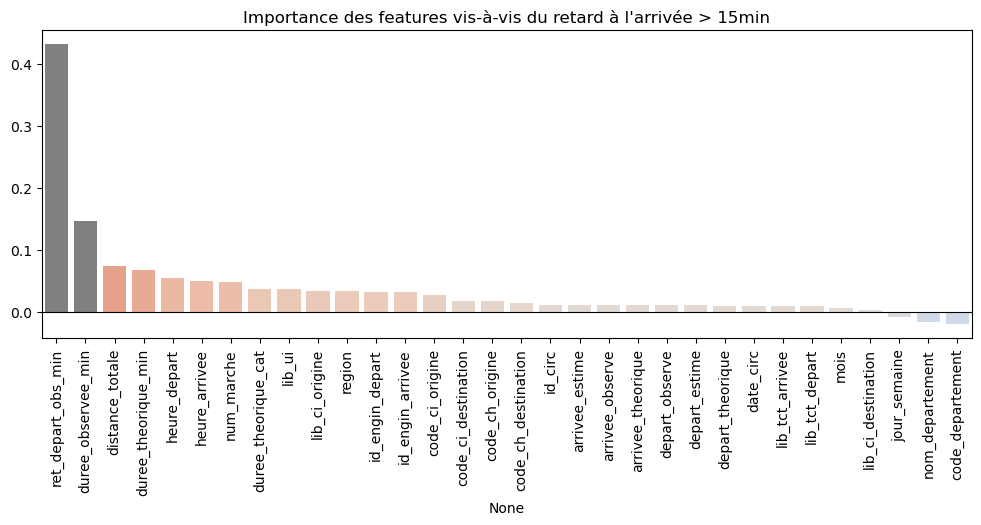

In [457]:
# Importance des features vis-à-vis du retard à l'arrivée > 15min

corr_series = df_encoded_corr.loc["ret_arrivee_15min"].sort_values(ascending=False)

# on exclut les colonnes non pertinentes (directement liées au retard à l'arrivée) :
corr_series = corr_series.drop(["ret_arrivee_15min", "ret_arrivee_10min", "ret_arrivee_5min", "ret_arrivee_obs_min"], errors='ignore')

# dégradé de couleurs
norm = plt.Normalize(-0.15, 0.15)
colors = (plt.cm.coolwarm(norm(corr_series.values))).tolist()

# on passe en gris les colonnes non connues à l'avance : 
unknown_cols = ["ret_depart_obs_min", "duree_observee_min"]
for i, col in enumerate(corr_series.index):
    if col in unknown_cols:
        colors[i] = (0.5, 0.5, 0.5, 1)  # gris

plt.figure(figsize=(12, 4))
sns.barplot(
    x=corr_series.index,
    y=corr_series.values,
    hue=corr_series.index,
    palette=colors
)
plt.xticks(rotation=90)
plt.title("Importance des features vis-à-vis du retard à l'arrivée > 15min")
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

plt.show()


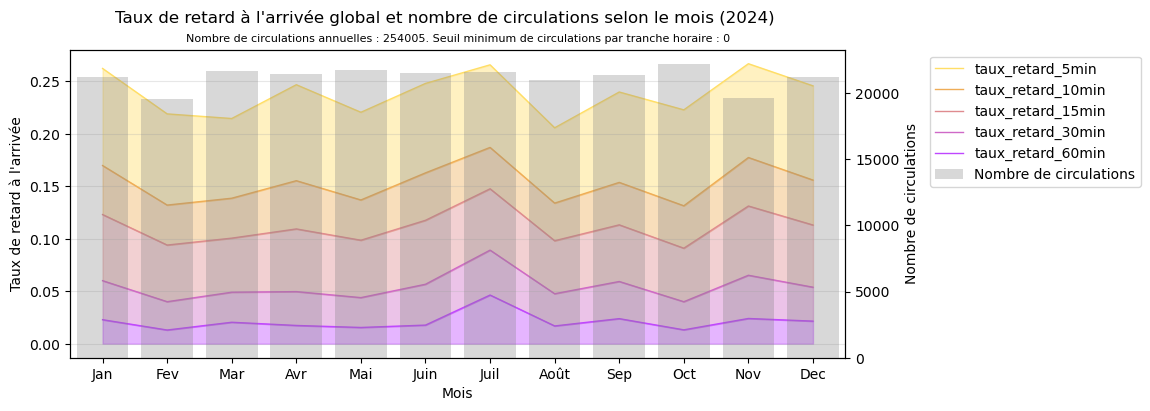

In [454]:
### Taux de retard à l'arrivée global et nombre de circulations selon le mois (2024)

seuil_trajets_annuels_mini = 0

# Probabilité d'être en retard à l'arrivée selon le mois
stats = df.groupby(["mois"]).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère le mois comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le mois (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Mois")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

# constat : juillet, seul mois de l'année où les très gros retards (>60 minutes) montent à 5% (contre 2-3% le reste de l'année)

plt.show()

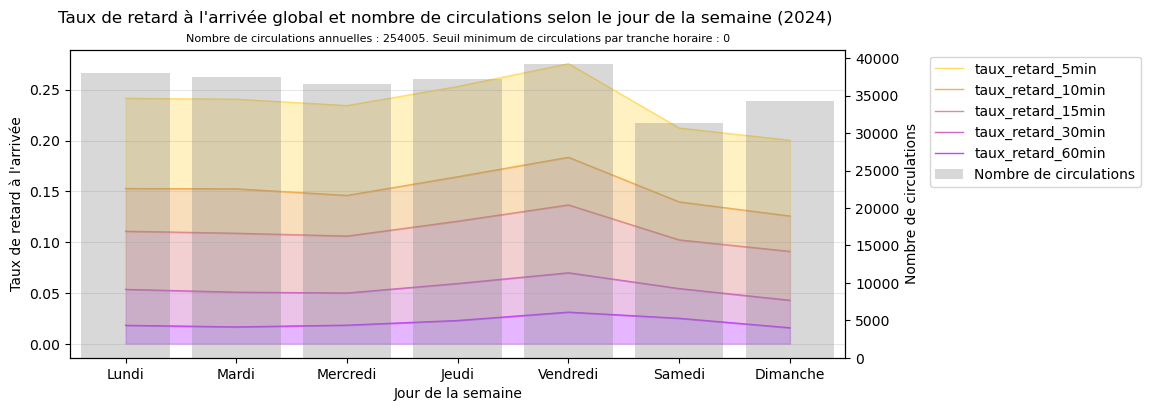

In [455]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine (2024)

seuil_trajets_annuels_mini = 0

# Probabilité d'être en retard à l'arrivée selon le jour de la semaine
stats = df.groupby(["jour_semaine"]).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère le jour de la semaine comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Jour de la semaine")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()

# constat : taux de retard plus élevé le vendredi, plus faible le weekend

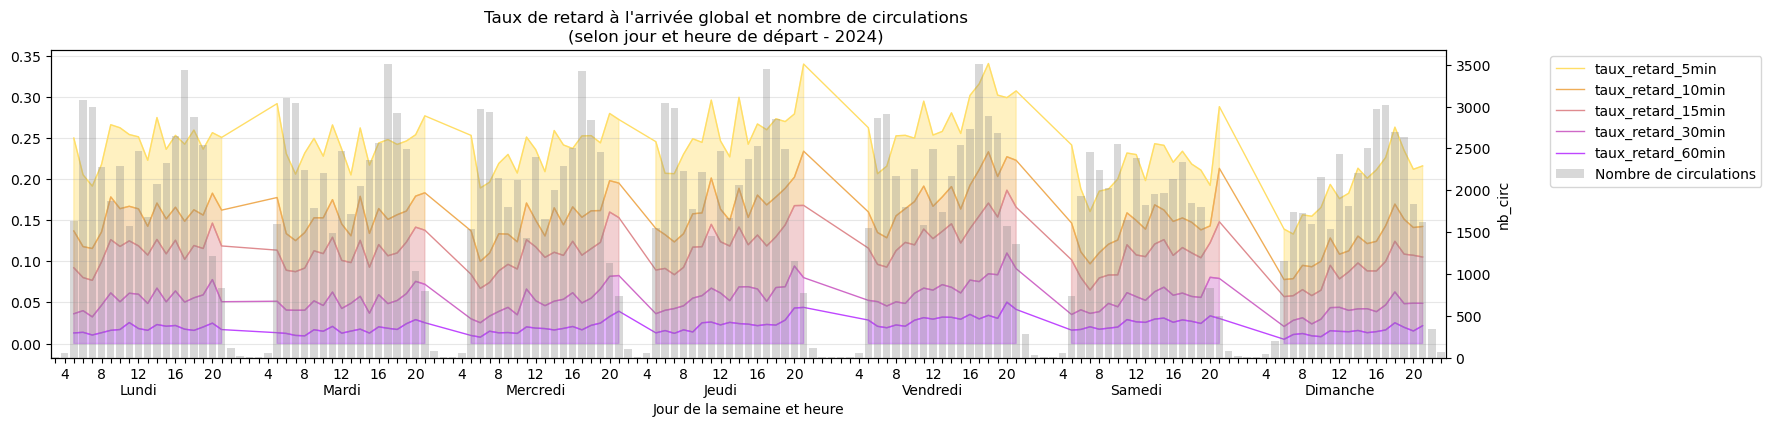

In [453]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine ET l'heure de départ (2024)

seuil_trajets_annuels_mini = 400

# Probabilité d'être en retard à l'arrivée selon le jour et l'heure de la semaine 
stats = df.groupby(["jour_semaine", "heure_depart"]).agg(
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
stats = stats.reset_index(names=['jour_semaine','heure_depart'])

# quand le nb_circ < seuil, on va ici remplaver la valeur des taux de retard par NaN 
# (pour ne pas afficher les taux sur ces plages horaires, qui sont biaisés par le faible nombre de trajets)
stats.loc[stats["nb_circ"] < seuil_trajets_annuels_mini,
          ["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
           "taux_retard_30min", "taux_retard_60min"]] = np.nan

# Graphique
plt.figure(figsize=(18, 4))
plt.suptitle("Taux de retard à l'arrivée global et nombre de circulations\n(selon jour et heure de départ - 2024)")
plt.xlabel("Jour de la semaine et heure")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min", 
                         "taux_retard_30min", "taux_retard_60min"]],
            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(range(len(stats)), stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.grid(axis='y', alpha=0.3)

# Axe secondaire
ax2 = ax.twinx()
sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")

# Légende unifiée
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.07, 1))

# Labels
heures_interet = [4, 8, 12, 16, 20]
jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
x_labels = []
for ligne in stats.values:
    jour_num, heure = ligne[0], ligne[1]
    heure_label = f"{heure:.0f}" if heure in heures_interet else ""
    x_labels.append(f"{heure_label}\n{jours_semaine[int(jour_num)] if heure == 12 else ""}")
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()


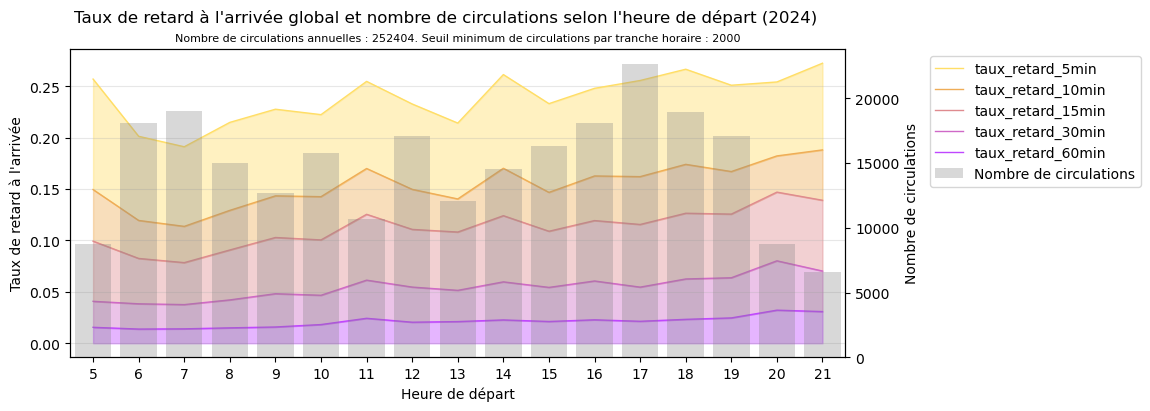

In [396]:
### Taux de retard à l'arrivée global et nombre de circulations selon l'heure de départ (2024)

seuil_trajets_annuels_mini = 2000

# Probabilité d'être en retard à l'arrivée selon l'heure de départ 
stats = df.groupby(["heure_depart"]).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère l'heure comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon l'heure de départ (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Heure de départ")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# Constat : les trains du matin (6-8h) sont globalement plus ponctuels que les trains du soir (17-21h)

# Note qui explique peut-être la différence avec les réusltats présentés par Le Monde : je considère uniquement les terminus, pas les arrêts intermédiaires. 
# et je considère tous les trains SLO, y compris des trains qui ne sont pas des TAGV (même s'ils sont minoritaires dans la base de données)

In [397]:
# Cas d'usages : taux de retard par heure selon la ville de départ et d'arrivée

def plot_retard_par_heure(depart, arrivée, seuil_trajets_annuels_mini=100):

    trajets_casdusage = df[(df["lib_ci_origine"].str.startswith(depart)) & (df["lib_ci_destination"].str.startswith(arrivée))]

    # Probabilité d'être en retard à l'arrivée selon l'heure de départ 
    stats = trajets_casdusage.groupby(["heure_depart"]).agg(
        retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
        retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
        taux_retard_5min = ('ret_arrivee_5min', 'mean'),
        taux_retard_10min = ('ret_arrivee_10min', 'mean'),
        taux_retard_15min = ('ret_arrivee_15min', 'mean'),
        taux_retard_30min = ('ret_arrivee_30min', 'mean'),
        taux_retard_60min = ('ret_arrivee_60min', 'mean'),
        nb_circ = ('id_circ', 'count')
    )

    # élimine les heures avec peu de circulations pour éviter le bruit
    stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

    # considère l'heure comme une chaine de caractères (pour l'affichage)
    stats.index = stats.index.astype(str)

    # Graphique :
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{depart} → {arrivée} : taux de retard à l'arrivée et nombre de circulations selon l'heure de départ (2024)")
    plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
    plt.xlabel("Heure de départ")

    # Taux de retard
    ax = plt.gca()
    colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
    lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                        "taux_retard_30min", "taux_retard_60min"]], 
                            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
    ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
    ax.set_ylabel("Taux de retard à l'arrivée")
    ax.grid(axis='y', alpha=0.3)

    # Nombre de circulations
    ax2 = ax.twinx()
    barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
    ax2.set_ylabel("Nombre de circulations")

    # Légende
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

    plt.show()

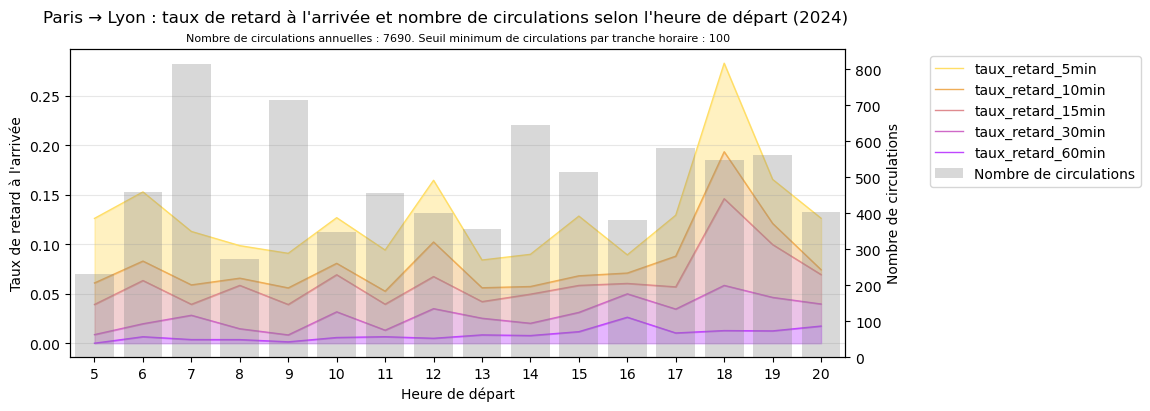

In [398]:
plot_retard_par_heure('Paris', 'Lyon', seuil_trajets_annuels_mini=100)

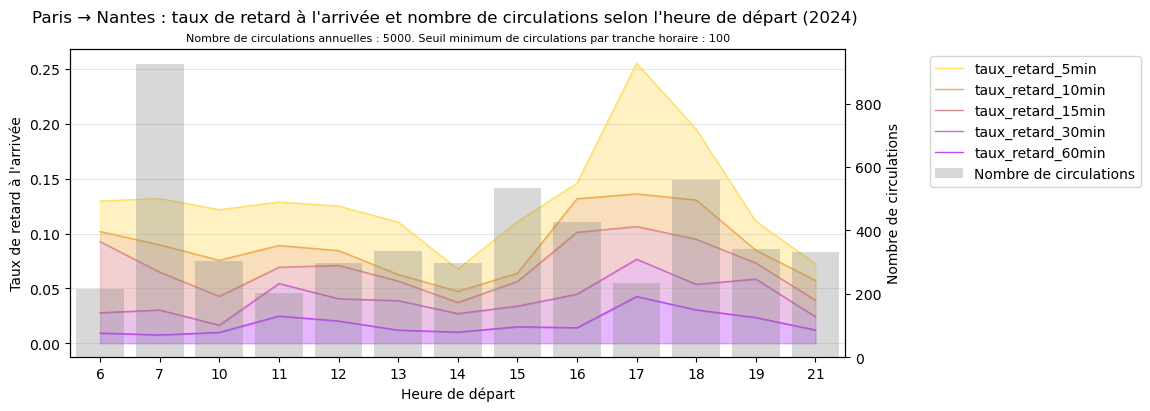

In [399]:
plot_retard_par_heure('Paris', 'Nantes', seuil_trajets_annuels_mini=100)

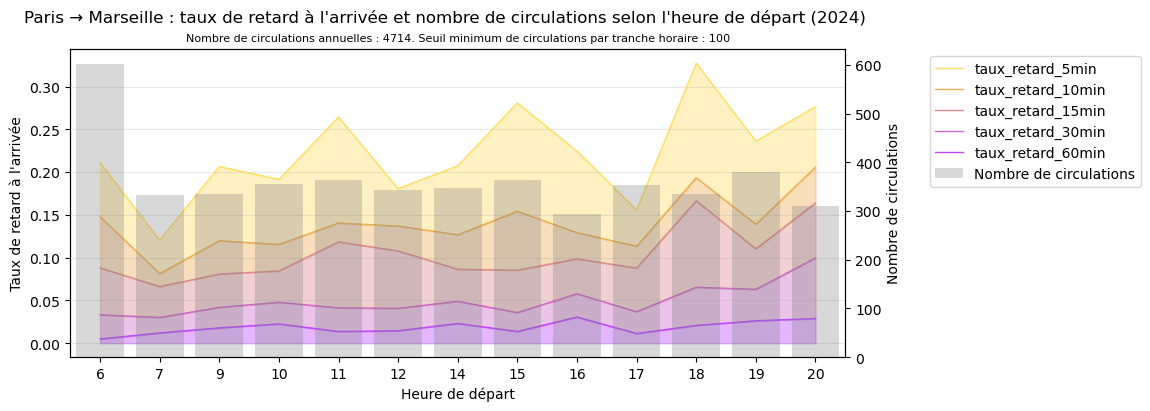

In [400]:
plot_retard_par_heure('Paris', 'Marseille', seuil_trajets_annuels_mini=100)

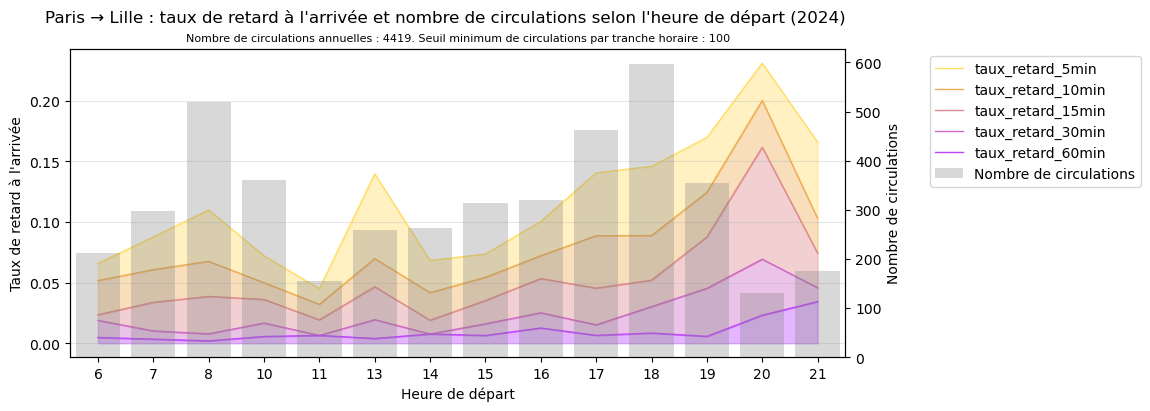

In [401]:
plot_retard_par_heure('Paris', 'Lille', seuil_trajets_annuels_mini=100)

In [251]:
# origines les plus fréquentes
df["lib_ci_origine"].value_counts().head(10)

lib_ci_origine
Paris-Gare-de-Lyon         33270
Paris-Montparnasse         26608
Paris-Nord                 18768
Paris-Est                  15217
Wannehain                  13588
Lyon-Perrache-Voyageurs    10175
Marseille-St-Charles        8921
Fréthun-Tunnel              8253
Nantes                      7637
Lille-Flandres              6898
Name: count, dtype: Int64

In [273]:
# destinations les plus fréquentes
df["lib_ci_destination"].value_counts().head(10)

lib_ci_destination
Paris-Gare-de-Lyon         32805
Paris-Montparnasse         26759
Paris-Nord                 19262
Paris-Est                  15149
Wannehain                  13027
Marseille-St-Charles        9504
Lyon-Perrache-Voyageurs     9196
Fréthun-Tunnel              8377
Nantes                      7590
Lille-Flandres              6636
Name: count, dtype: Int64

In [253]:
# liste des destinations les plus fréquentes, à partir d'une ville donnée
origine = "Paris"
df[df["lib_ci_origine"].str.startswith(origine)]["lib_ci_destination"].value_counts().head(10)

lib_ci_destination
Lyon-Perrache-Voyageurs    7167
Wannehain                  6767
Fréthun-Tunnel             5191
Nantes                     5106
Marseille-St-Charles       4830
Lille-Flandres             4461
Bordeaux-St-Jean           3311
Quimper                    3074
Pougny-Chancy              2648
La Rochelle-Ville          2641
Name: count, dtype: Int64